# White noise filtering autoencoder

In this notebook, we are examining whether the autoencoder can be trained to filter noise of different strengths from the data. To do this, we have generated some spectra without noise, with medium noise and with strong noise. Let's have a look at one of the spectra, to see what the noise looks like:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
layers = keras.layers

#importing the data
X_nonoise = np.loadtxt("qcs_nonoise.txt", delimiter=",")
X_littlenoise = np.loadtxt("qcs_noise1.txt", delimiter=",")
X_mediumnoise = np.loadtxt("qcs_noise3.txt", delimiter=",")
X_strongnoise = np.loadtxt("qcs_noise6.txt", delimiter=",")
X_extremenoise = np.loadtxt("qcs_noise10.txt", delimiter=",")
X_noisec05 = np.loadtxt("qcs_noisec05.txt", delimiter=",")
X_noisec = np.loadtxt("qcs_noisec1.txt", delimiter=",")

#assigning a key to each dataset
data = {
    "n": X_nonoise,
    "l": X_littlenoise,
    "m": X_mediumnoise,
    "s": X_strongnoise,
    "e": X_extremenoise,
    "ch": X_noisec05,
    "c": X_noisec}

#epsilon_std values used when generating the spectra with the function make_spectra_v1()
noise_eps = {"n": 0,
             "l": 1e-4,
             "m": 3e-4, 
             "s": 6e-4,
             "e": 1e-3,
             "ch": 0.5e-2,
             "c": 1e-2}

noise_labels = {"n": "No noise",
             "l": "Low noise",
             "m": "Medium noise", 
             "s": "Strong noise",
             "e": "Very strong noise",
             "ch": "Extreme noise"}

#splitting data into train and test set
from sklearn.model_selection import train_test_split
#setting the shuffle parameter to false, because we need to match the spectra with and without noise
train = {}
test = {}
for key, dataset in data.items():
        tr, te = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=False, stratify=None)
        train[key] = tr
        test[key] = te

#standard scaling the training and testing data 
#(we need to do it manually because standardscaler only remembers one mean and stddev)

def standard_scale(X, m, s):
    return (X-m)/s

def rescale(X, m, s):
    return X*s+m

scaled_train = {}
scaled_test = {}
means_train = {}
means_test = {}
stddevs_train = {}
stddevs_test = {}


for key, dat in train.items():
    mean_train = np.mean(dat, axis=1, dtype=np.float64)
    stddev_train = np.std(dat, axis=1, dtype=np.float64)
    scaled_tr = np.array([standard_scale(dat[i], mean_train[i], stddev_train[i]) for i in range(len(dat))])
    scaled_train[key] = scaled_tr
    means_train[key] = mean_train
    stddevs_train[key] = stddev_train
          
for key, dat in test.items():
    mean_test = np.mean(dat, axis=1, dtype=np.float64)
    stddev_test = np.std(dat, axis=1, dtype=np.float64)
    scaled_te = np.array([standard_scale(dat[i], mean_test[i], stddev_test[i]) for i in range(len(dat))])
    scaled_test[key] = scaled_te
    means_test[key] = mean_test
    stddevs_test[key] = stddev_test

In [2]:
scaled_train['n'].shape[1]

1101

This is how the noisy spectra look like

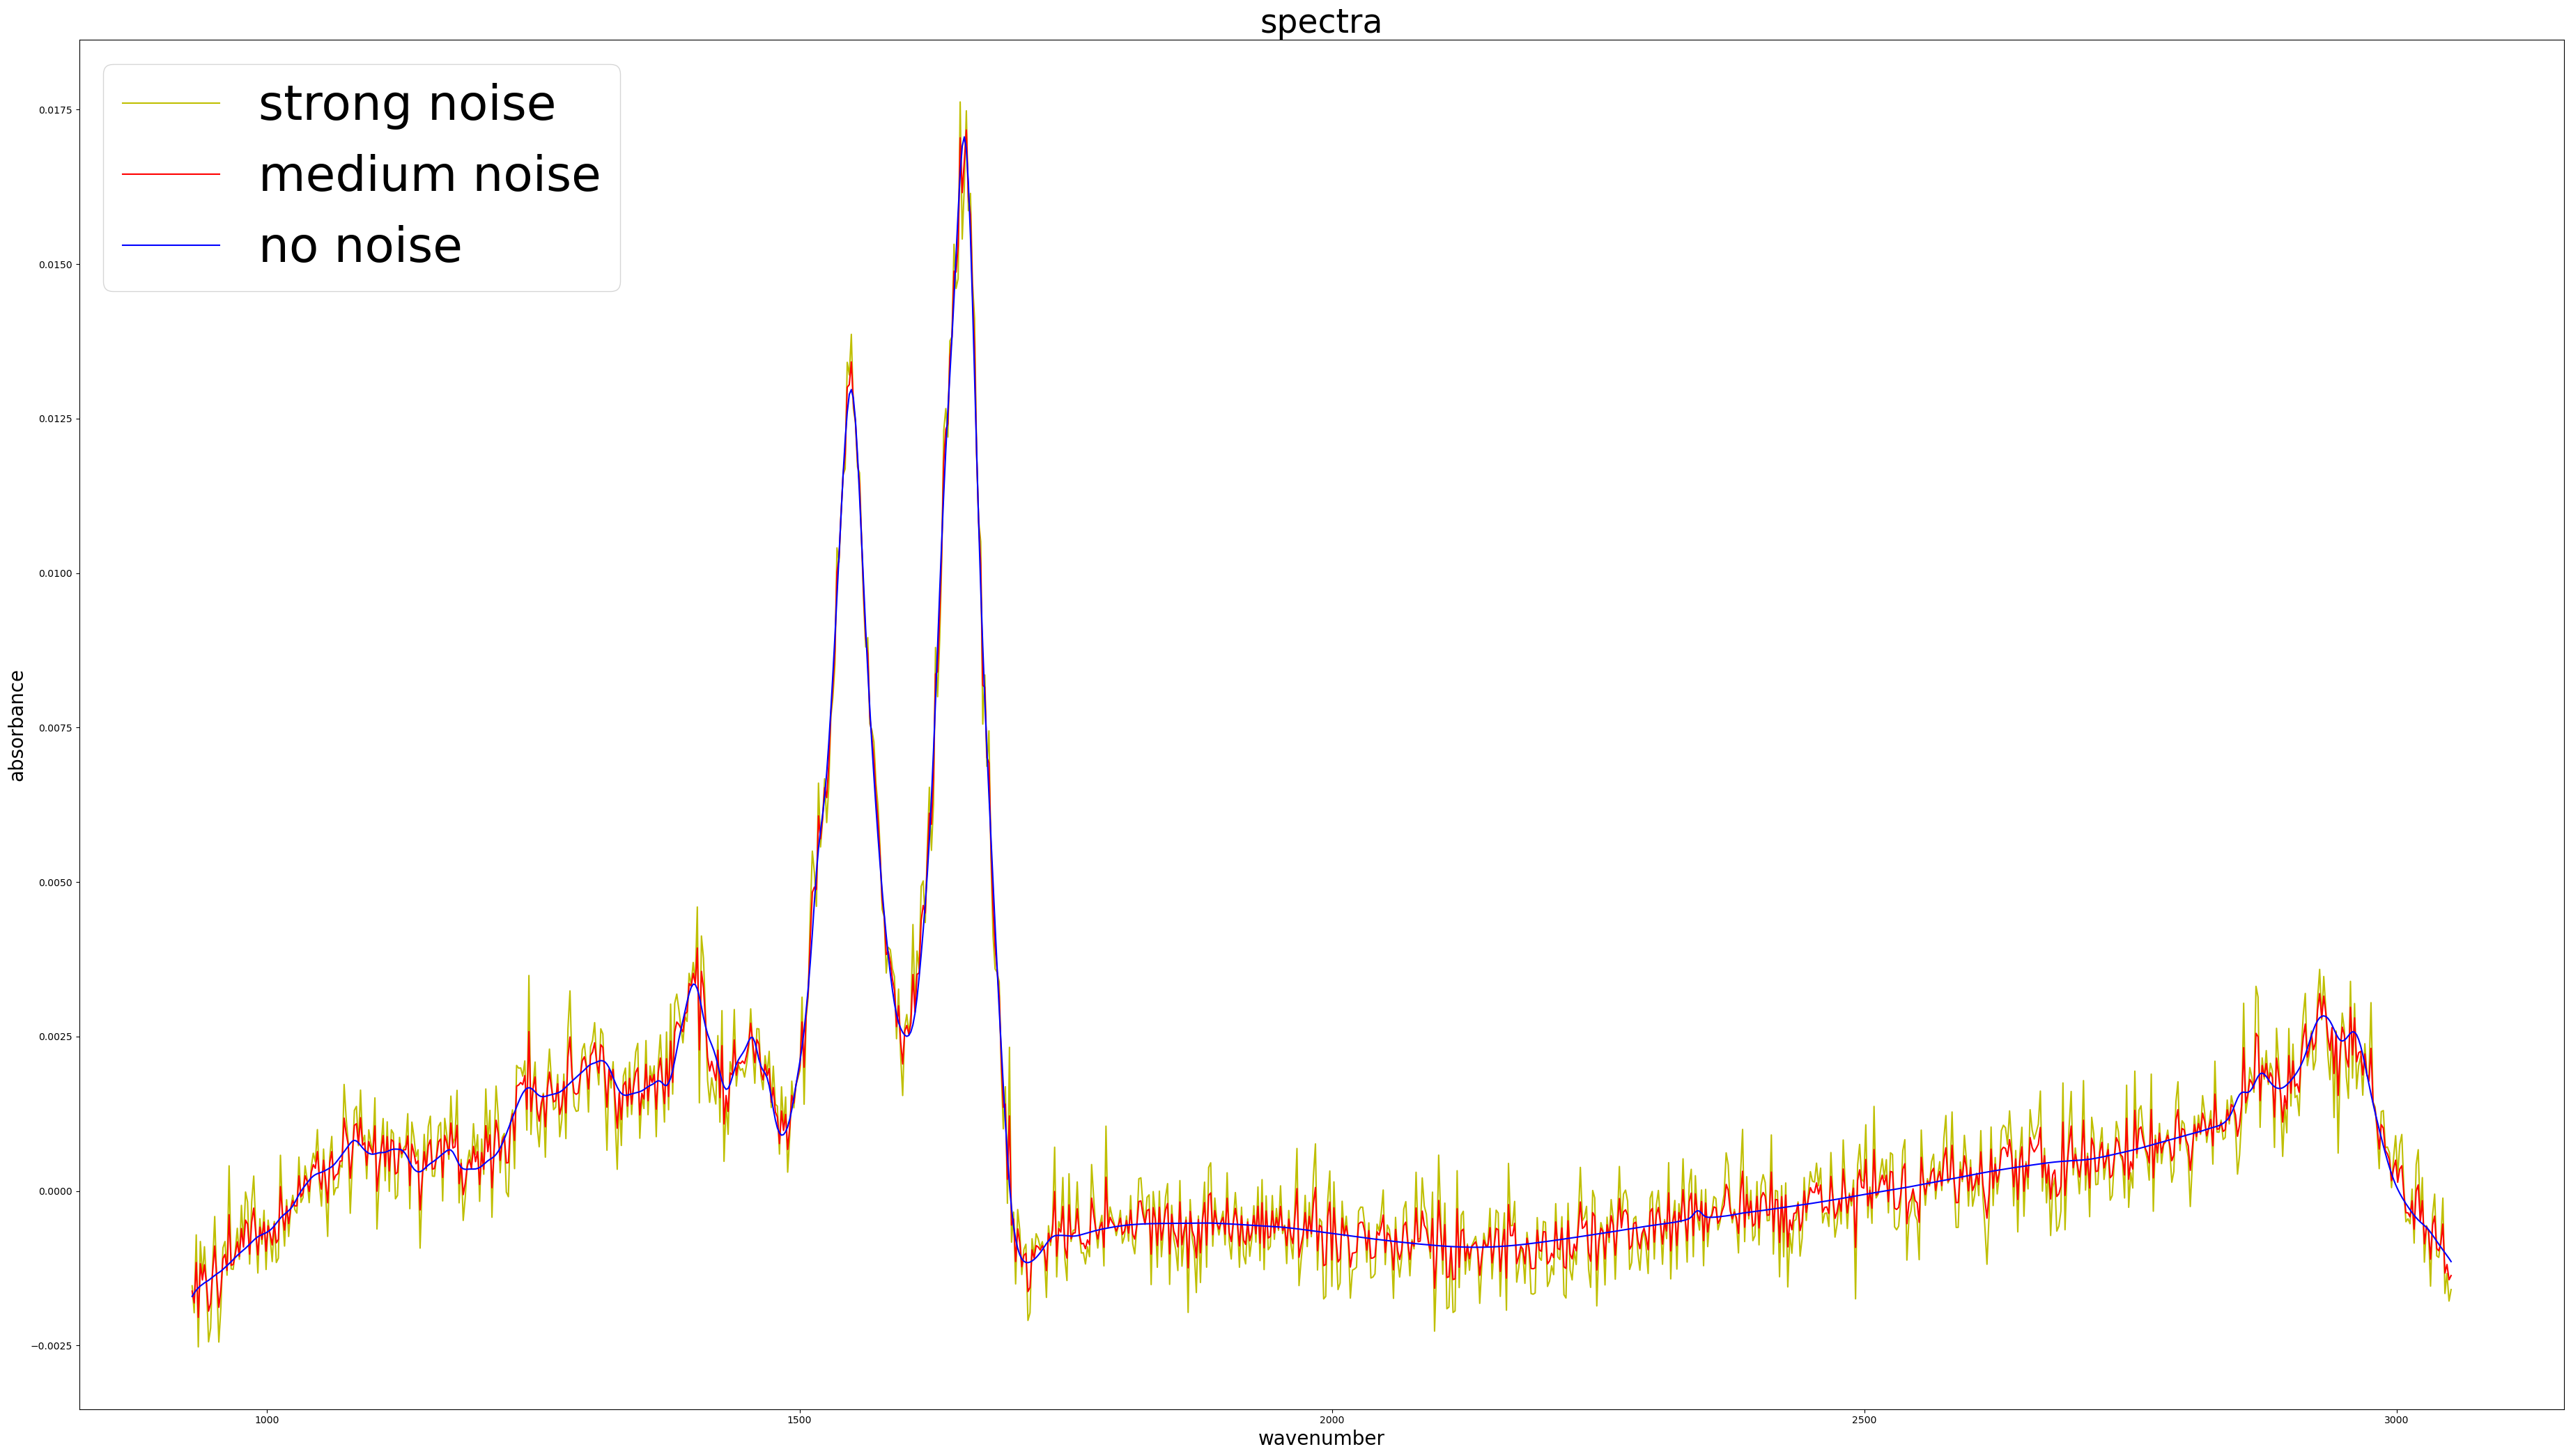

In [2]:
plots = 1
n_test = X_nonoise.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,X_nonoise.shape[1])

plt.figure(figsize= (18.5 * 2, 10.5 * 2))
plt.plot(xaxis, X_strongnoise[idx[0]], 'y', label="strong noise")
plt.plot(xaxis, X_mediumnoise[idx[0]], 'r', label="medium noise")
plt.plot(xaxis, X_nonoise[idx[0]],'b', label="no noise") 
plt.legend(loc=2, prop={'size': 50})
plt.xlabel('Wavenumber [cm$^-1$]', fontsize=20)
plt.ylabel('Absorbance [a.u.]', fontsize=20)
plt.title("spectra", fontsize = 34) 
plt.tight_layout()
plt.show()

Defining the model

In [3]:
def create_model(name):
    activation = "elu"

    inputlayer = layers.Input(shape=scaled_train['n'].shape[1])
    e2 = layers.Dense(500, activation=activation)(inputlayer)
    e3 = layers.Dense(250, activation=activation)(e2)
    dropout = layers.Dropout(0.3)(e3)
    e4 = layers.Dense(100)(dropout)

    encoded = layers.Dense(50)(e4)

    d1 = layers.Dense(100, activation=activation)(encoded)
    d2 = layers.Dense(250, activation=activation)(d1)
    d3 = layers.Dense(500, activation=activation)(d2)
    outputlayer = layers.Dense(1101, activation="linear")(d3)

    model = keras.models.Model(inputlayer, outputlayer, name=name)    
    return model

Compiling and training the models

In [4]:
results = {}
models = {}

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

for key, trainset in scaled_train.items():
    name = f'autoencoder_noise_{key}'
    model = create_model(name)
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')
    #Training on medium and strong noise
    result = model.fit(trainset, scaled_train['n'],
                          epochs=50,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=0,
                          callbacks=[earlystopping, rl_on_plateau])
    results[key] = result
    #model.save(name)
    models[key] = model


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003007630087086.
Epoch 10: early stopping

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003007630087086.

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002015112101798877.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00013501251160050743.

Epoch 14: ReduceLROnPlateau reducing learning rate to 9.04583813098725e-05.

Epoch 16: ReduceLROnPlateau reducing learning rate to 6.060711421014276e-05.

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.060676725202939e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 2.720653359574499e-05.

Epoch 22: ReduceLROnPlateau reducing learning rate

Monitoring the training

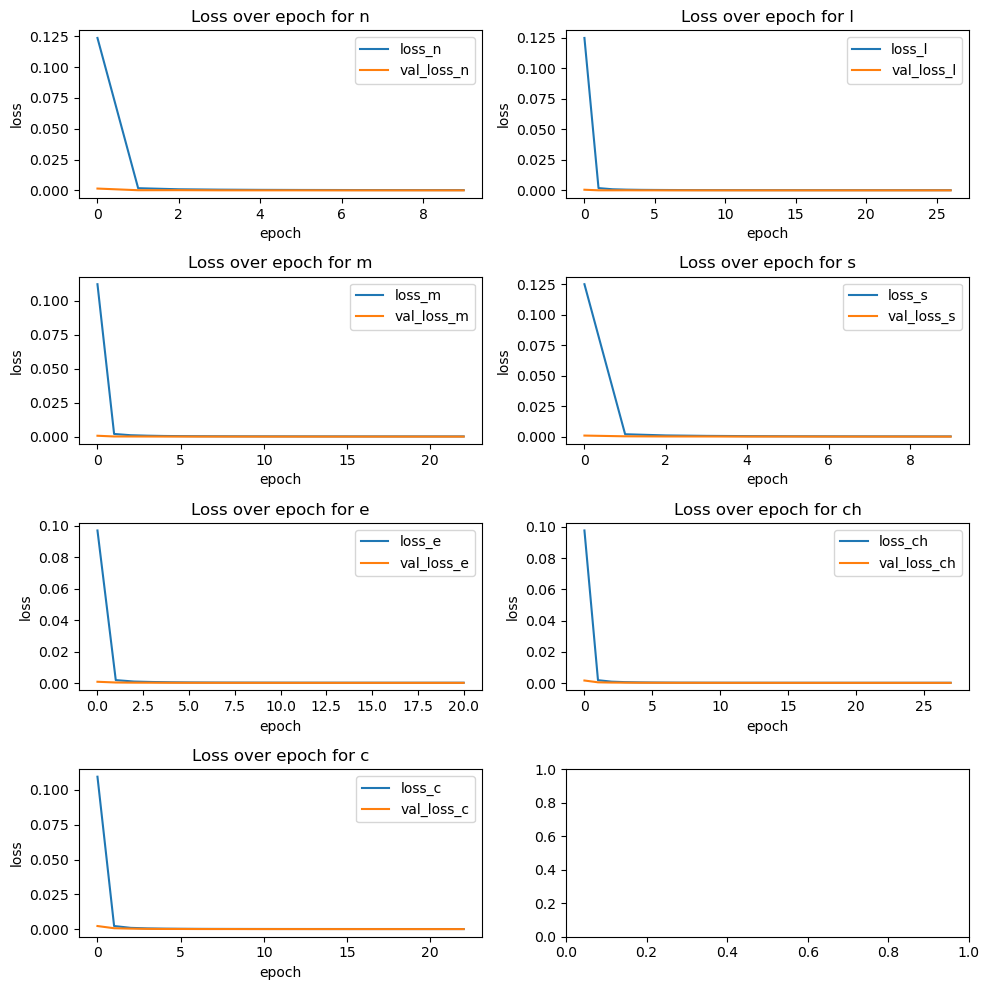

In [5]:
size = 10
fig, ax = plt.subplots(4, 2, figsize=(size, size))

i=0
j=0
for key, res in results.items():
    ax[i, j].plot(res.history['loss'], label = f'loss_{key}')
    ax[i, j].plot(res.history['val_loss'], label = f'val_loss_{key}')
    ax[i, j].set_ylabel('loss')
    ax[i, j].set_xlabel('epoch')
    ax[i, j].set_title(f'Loss over epoch for {key}')
    ax[i, j].legend(loc='upper right')
    #move to the next subplot
    if j==0:
        j+=1
    else:
        j=0
        i+=1    
        
plt.tight_layout()

Let's see how the denoised spectra look like compared to the not noisy spectra and the noisy spectra

In [6]:
preds = {}

for key,model in models.items():
    pred = model.predict(scaled_test[key], verbose=2)
    #Rescaling the data for the plots. Using the StandardScaler from scikit would require to train it. We just do it manually.
    preds_rescaled = [rescale(pred[i], means_test[key][i], stddevs_test[key][i]) for i in range(len(pred))]
    preds[key] = preds_rescaled

63/63 - 0s - 191ms/epoch - 3ms/step
63/63 - 0s - 139ms/epoch - 2ms/step
63/63 - 0s - 125ms/epoch - 2ms/step
63/63 - 0s - 131ms/epoch - 2ms/step
63/63 - 0s - 135ms/epoch - 2ms/step
63/63 - 0s - 137ms/epoch - 2ms/step
63/63 - 0s - 122ms/epoch - 2ms/step


Medium noise:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


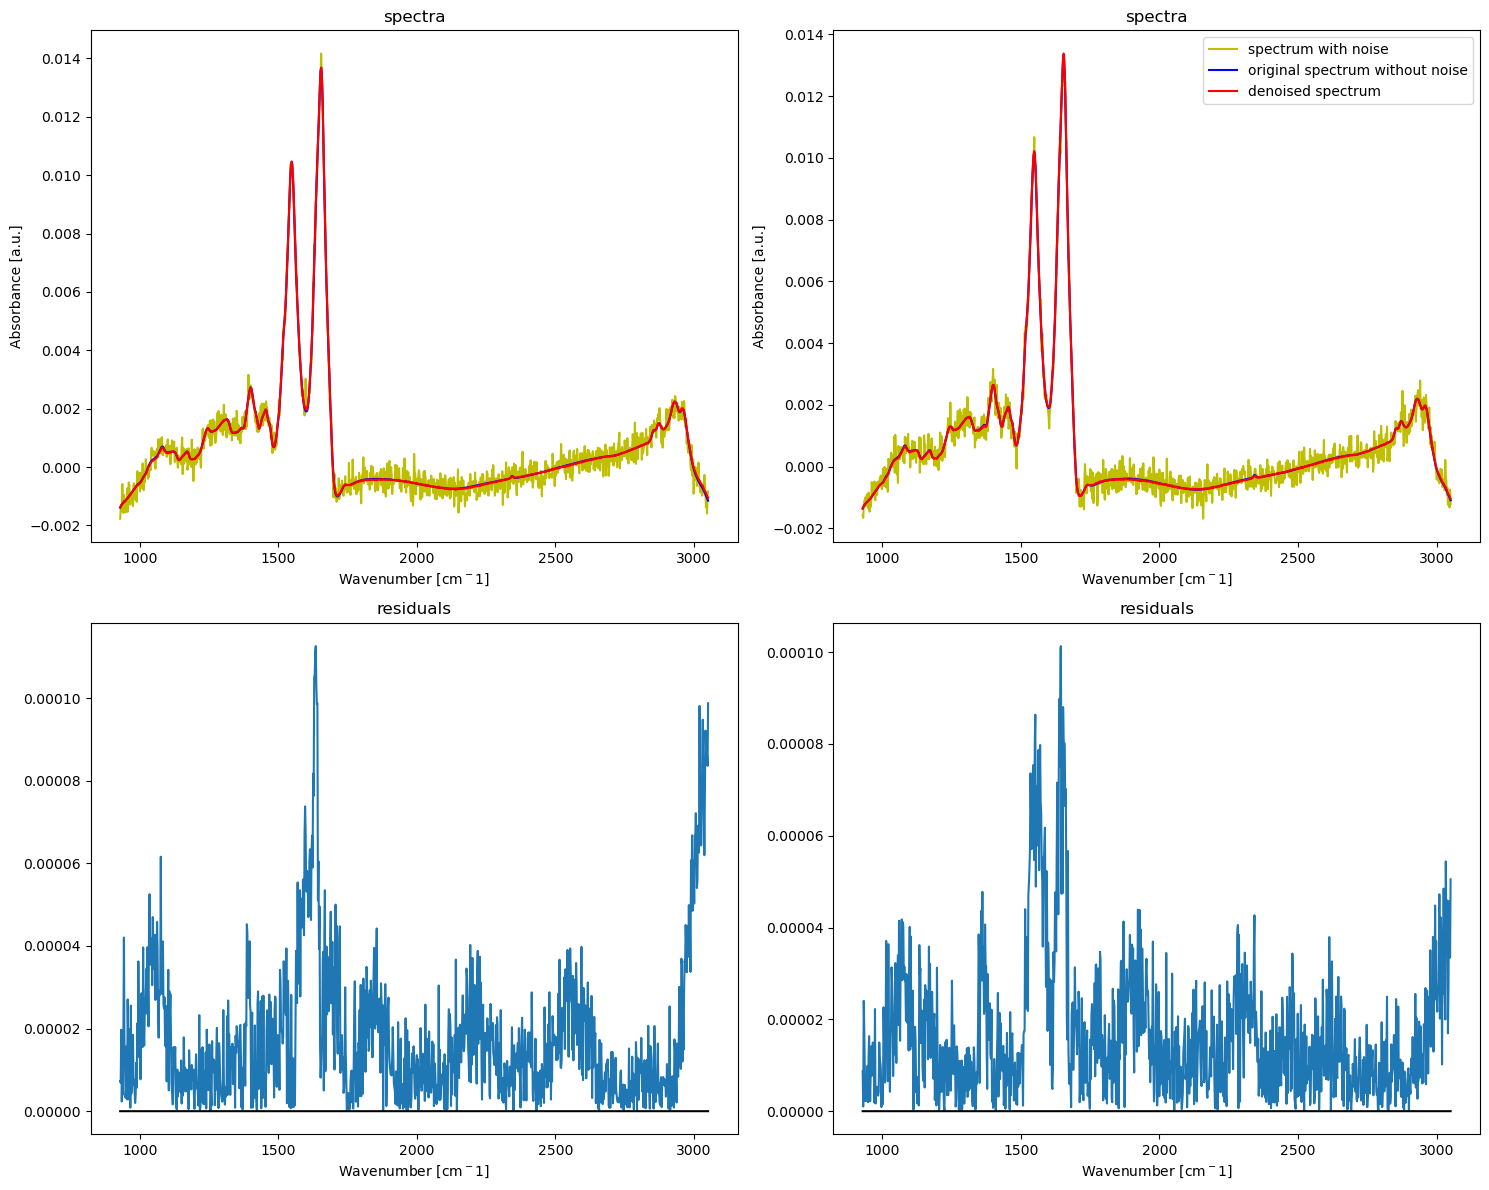

In [7]:
def plot_two_examples(key, save=False):
    plots = 2
    n_test = scaled_test[key].shape[0]
    idx = np.random.choice(n_test, plots)
    xaxis = np.linspace(929.52720343237377,3050.8548461203636,scaled_test[key].shape[1])

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

    for i in range(plots):
        ax1[i].plot(xaxis, test[key][idx[i]], 'y', label = "spectrum with noise")
        ax1[i].plot(xaxis, test['n'][idx[i]],'b', label="original spectrum without noise")
        ax1[i].plot(xaxis, preds[key][idx[i]], 'r', label="denoised spectrum")
    
        ax1[1].legend(loc=1)
        ax1[i].set_xlabel('Wavenumber [cm$^-1$]')
        ax2[i].set_xlabel('Wavenumber [cm$^-1$]')
        ax1[i].set_ylabel('Absorbance [a.u.]')
        ax1[i].set_title("spectra")

        ax2[i].plot(xaxis, np.abs(test['n'][idx[i]]-preds[key][idx[i]]), label="residuals")
        ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
        ax2[i].set_title("residuals")
    
    plt.tight_layout()
    plt.show()
    if save==True:
        plt.savefig("")     
    return None

plot_two_examples("m")

Strong noise:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


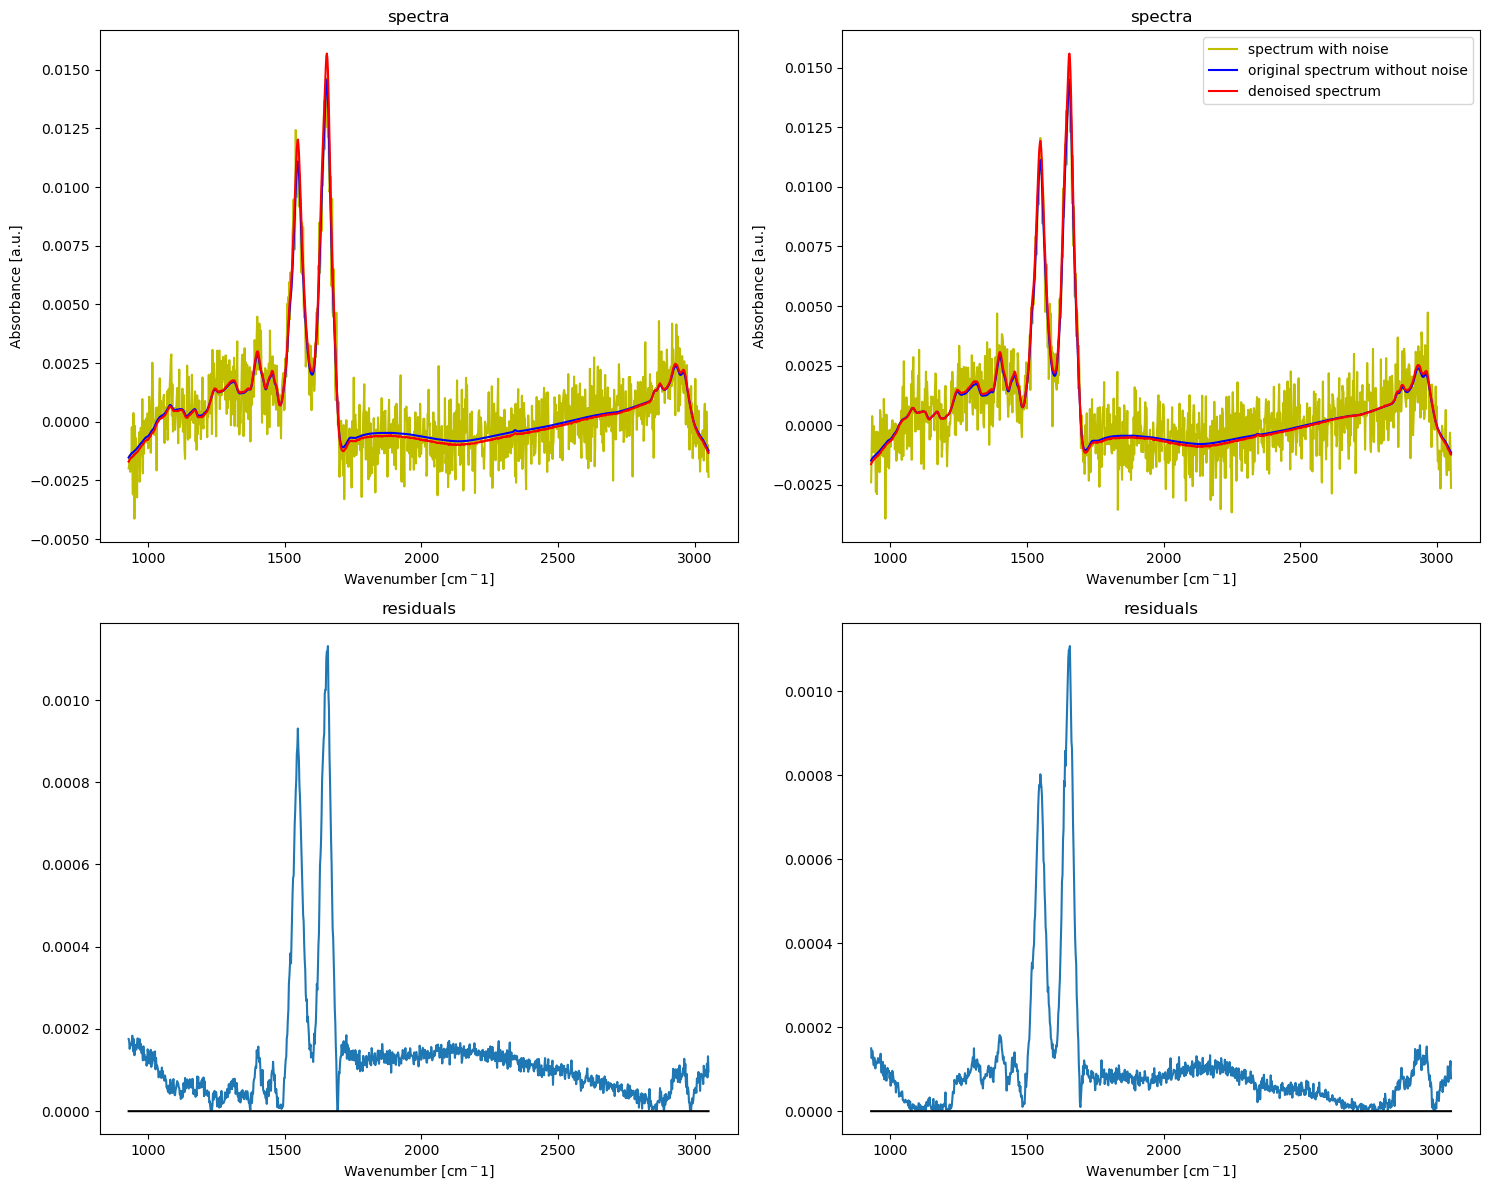

In [8]:
plot_two_examples('e', save=False)

Extreme noise:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


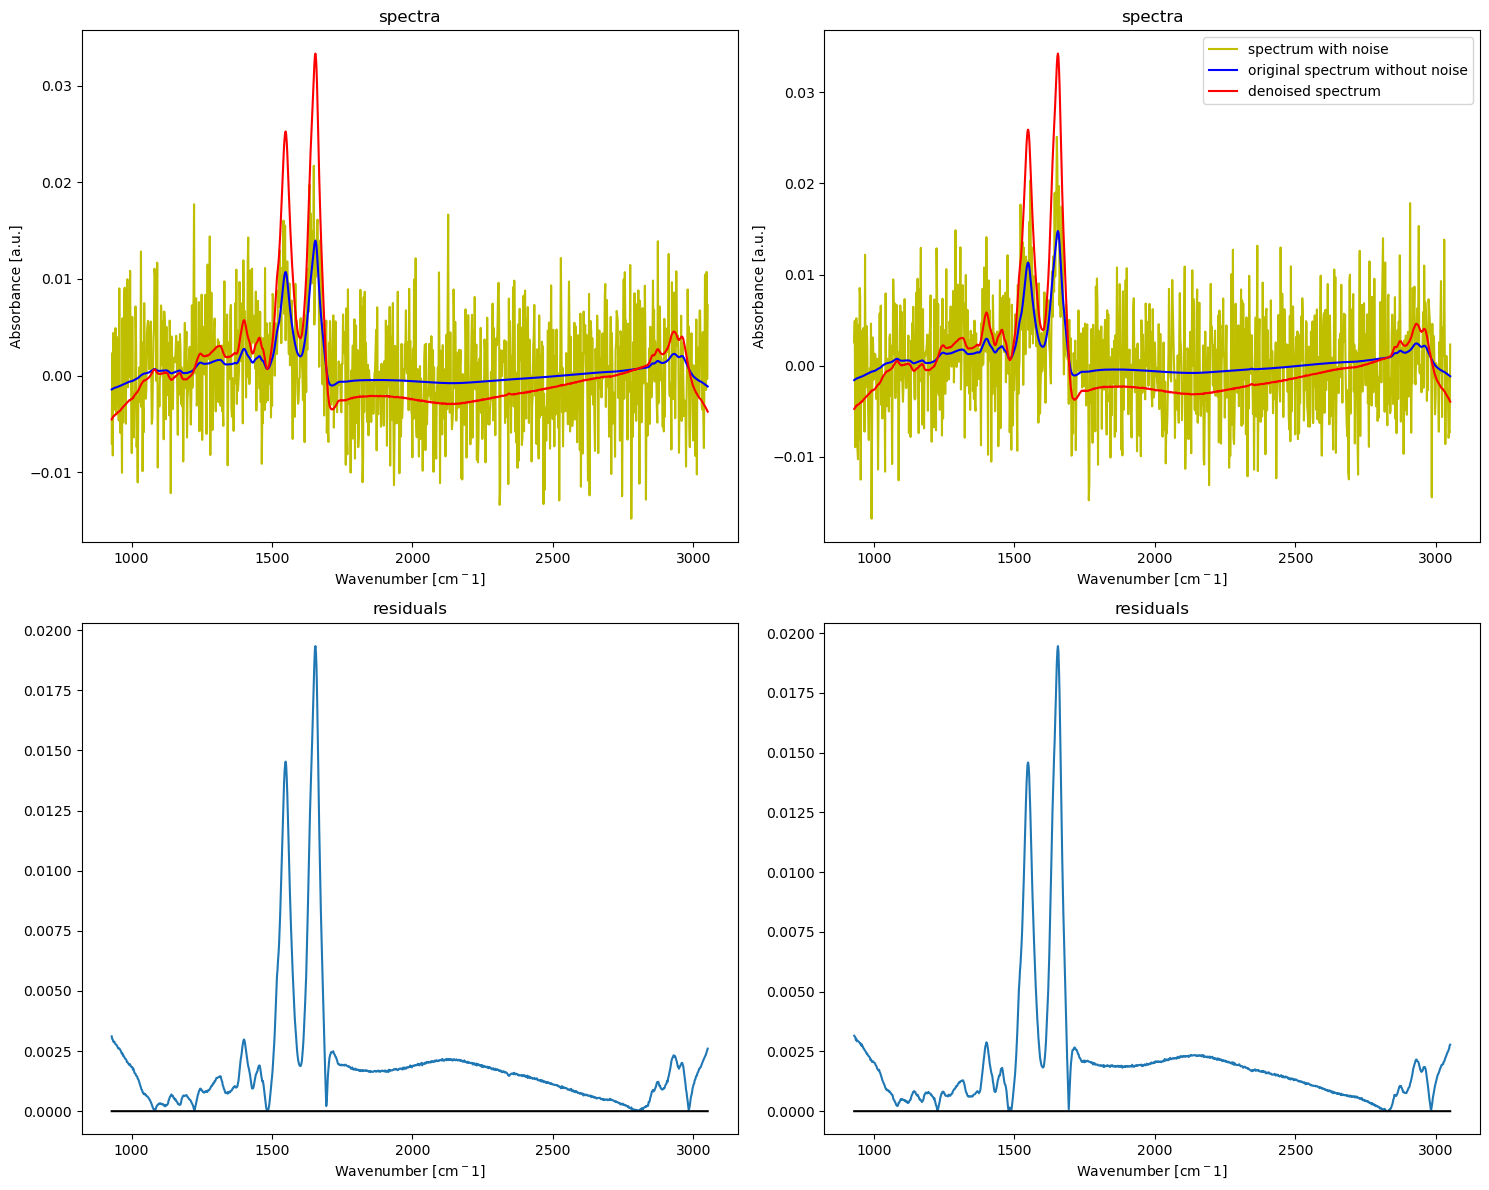

In [9]:
plot_two_examples('ch', save=False)

0 0 n 0
0 1 l 1
1 0 m 2
1 1 s 3
2 0 e 4
2 1 ch 5


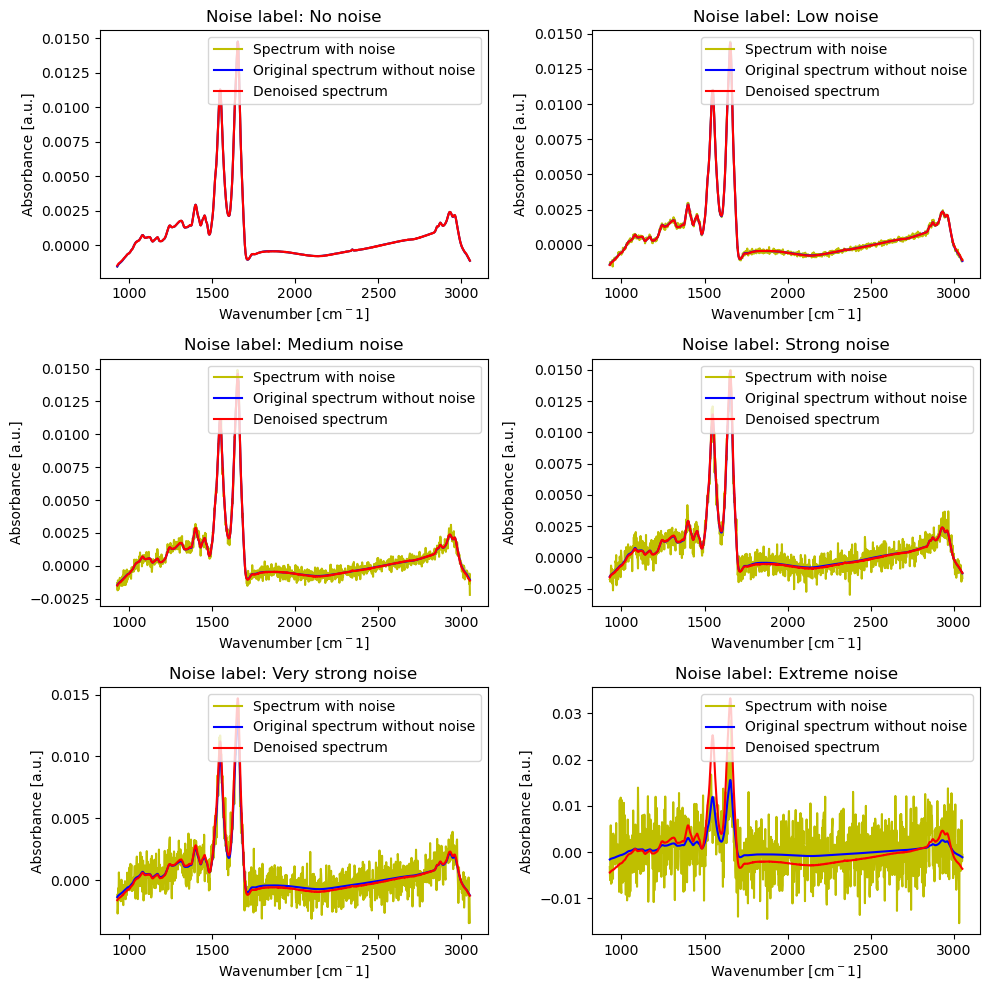

In [17]:
plots = 6
n_test = scaled_test[key].shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,scaled_test[key].shape[1])

size = 10
fig, ax = plt.subplots(3, 2, figsize=(size, size))

i=0
j=0
k=0
for key, eps in noise_labels.items():
    ax[i, j].plot(xaxis, test[key][idx[k]], 'y', label = "Spectrum with noise")
    ax[i, j].plot(xaxis, test['n'][idx[k]],'b', label="Original spectrum without noise")
    ax[i, j].plot(xaxis, preds[key][idx[k]], 'r', label="Denoised spectrum")
    ax[i, j].legend(loc=1)
    ax[i, j].set_xlabel('Wavenumber [cm$^-1$]')
    ax[i, j].set_ylabel('Absorbance [a.u.]')
    ax[i, j].set_title(f'Noise label: {eps}')
    ax[i, j].legend(loc='upper right')
    #move to the next subplot
    print(i,j, key, k)
    k+=1
    if j==0:
        j+=1
    else:
        j=0
        i+=1    
        
#plt.title("Example spectra for selected noise strengths")
plt.tight_layout()

[ 2.57873634e-06  3.24341257e+02 -2.92680308e-06]


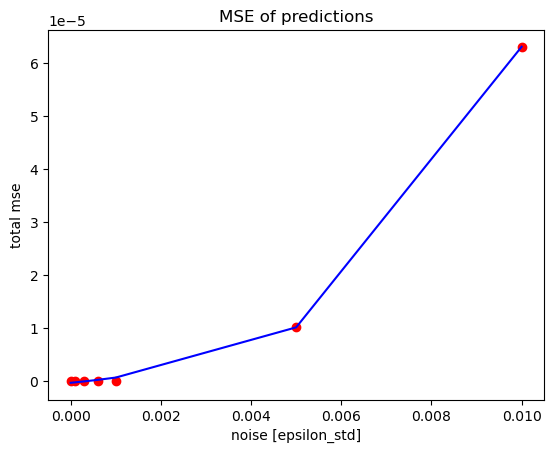

In [18]:
#Total MSE over all predictions
def total_mse(predictions, originals):
    residuals = [(originals[i]-predictions[i])**2 for i in range(len(originals))]
    lrow=0
    for i in range(len(residuals)):
        lrow += len(residuals[i])
    return sum(sum(residuals))/lrow


#Plotting the total MSE for the different noise
x = list(noise_eps.values())
y = [total_mse(preds[k], test['n']) for k in preds.keys()]
plt.plot(x, y, 'ro')
plt.xlabel("noise [epsilon_std]")
plt.ylabel("total mse")
plt.title("MSE of predictions")

#Fitting a curve (exponential) to the data points
from scipy.optimize import curve_fit
def exponential(x, a, b, c):
    return a*np.exp(b*x)+c

popt, pcov = curve_fit(exponential, x, y)
plt.plot(x, [exponential(i, *popt) for i in x], 'b')

print(popt)

Text(0.5, 1.0, 'MSE of predictions')

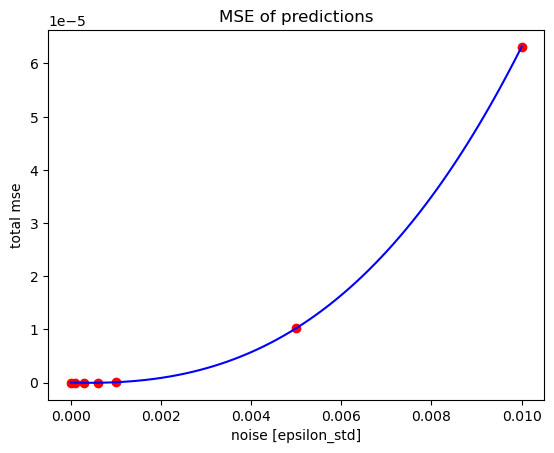

In [19]:
mymodel = np.poly1d(np.polyfit(x, y, 3))

myline = np.linspace(0,0.01,100)

plt.plot(x, y, 'ro')
plt.plot(myline, mymodel(myline), 'b')
plt.xlabel("noise [epsilon_std]")
plt.ylabel("total mse")
plt.title("MSE of predictions")

In [20]:
mymodel

poly1d([ 3.96339247e+01,  2.59673948e-01, -2.48979260e-04,  2.51465870e-08])

Conclusion: Increasing the noise results in (exponentially?) rising mse of original and reproduced spectra. However, it works quite decent even for epsilon_std = 0.001. For epsilon_std >= 0.005 the model architecture isn't able to reproduce and denoise properly.

Now we want to see if the information stored in the spectra can be restored from the denoised spectra.